# Trabalho #6 - One shot learning para classificação multiclasse

Nesse trabalho você vai desenvolvver um classificador de imagens de caracteres de alfabetos usando o método "one shot learning". 

O objetivo desse trabalho é verificar se o seu aprendizado na disciplina foi efetivo, assim, você vai ter que desenvolver quase todo o código para realizar o trabalho. Somente é fornecida uma função para carregar as imagens do conjunto de dados e salvá-las em tensores. 

O conjunto de dados utilizado tem que ser carregado da internet conforme indicado a seguir.

## Coloque o seu  nome aqui:

Nome: Rodrigo Franciozi Rodrigues da Silva

### Importação das principais bibliotecas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Definição do problema


Nesse trabalho será usado o conjunto de dados Omniglot, que consiste de uma coleção de 1928 caracteres desenhados à mão de 50 alfabetos diferentes. Para cada caractere existem apenas 20 exemplos,

Somente para ressaltar, o nosso alfabeto contém 26 caracteres (ou letras). Esse conjunto de dados contém 1.928 caracteres de todos os 50 alfabetos.

A figura abaixo apresenta algumas imagens de caracteres de diferentes alfabetos para se ter uma ideia melhor do conjunto de dados.

<br>
<img src="Exemplos.jpg">

<center> Fonte: https://sorenbouma.github.io/blog/oneshot/ </center>


O objetivo desse trabalho é identificar os caracteres a partir de imagens, ou seja, é um trabalho de classificação multiclasse. Contudo, esse conjunto de dados contém 1.928 classes diferentes (cada caractere consiste de uma classe) e para cada classe tem-se apenas 20 imagens. Obviamente, se for tentado resolver este problema usando o método tradicional de classificação multiclasse de imagens, então definitivamente não será possível construir um bom modelo capaz de generalizar. Além disso, dado o pequeno número de imagens disponíveis para cada classe, o modelo facilmente terá problemas de "overfitting".

## 2. Conjunto de dados

Você pode baixar o conjunto de dados do repositório GitHub (https://github.com/brendenlake/omniglot). Esse conjunto de dados foi desenvolvido por: "Lake, B. M., Salakhutdinov, R. e Tenenbaum, J. B. (2015), Human-level concept learning through probabilistic program induction. Science, 350 (6266), 1332-1338." 

A pasta chamada “Python” contém dois arquivos zip: `images_background.zip` e `images_evaluation.zip`. Basta descompactar somente esses dois arquivos. 

Depois de descompactar esses arquivos, existirão duas pastas: 

- A pasta `images_background` contém caracteres de 30 alfabetos e que serão usados para treinar o modelo;
- A pasta `images_evaluation` contém caracteres dos outros 20 alfabetos que serão usados para testar o modelo.


Em cada uma dessas pastas existem subdiretórios com os diversos alfabetos. O conteúdo da pasta `images_background` com os dados de treinamento, é o seguinte:

<br>

<img src="Images_background.jpg">
          
<br>

O conteúdo da pasta `images_evaluation`, com os dados de validação e teste, é o seguinte:

<br>

<img src="Images_evaluation.jpg">
          
<br>

Observe que o modelo será treinado com um conjunto de caracteres e depois testado com um conjunto de caracteres completamente diferente, que nunca foi usado durante o treinamento. Isso não é possível com um modelo de classificação multiclasse tradicional.

### 3.1 Carregar conjunto de dados

Para carregar o conjunto de dados execute a célula abaixo para criar a função que le as imagens nos arquivos e as carrega em tensores.

In [3]:
# Importa função para carregar as imagens
from skimage.io import imread

# Função para carregar as imagens e classes e colocá-las em tensores 
def loadimgs(path, n = 0):
    '''
    path => diretório onde estão as imagens de treinamento ou de validação
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # Carrega cada alfabeto separadamente para facilitar o seu uso
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # Cada caractere é carregado separadamente e colocado em subdiretórios sepraddos
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # Carrega todas as imagens do diretório corrente
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))

            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
            
    y = np.vstack(y)
    X = np.stack(X)
    
    return X, y, lang_dict

Defina os nomes dos diretórios onde se encontram as imagens de treinamento e de teste e execute a célula abaixo para carregar as imagens nos respetivos tensores.

In [4]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/Education/IMT/Pós Graduação/Convolutional Neural Networks and Computer Vision/T6/images_background.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

with zipfile.ZipFile("/content/drive/MyDrive/Education/IMT/Pós Graduação/Convolutional Neural Networks and Computer Vision/T6/images_evaluation.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

In [5]:
print('Carregando dados de treinamento:')
train_folder = "targetdir/images_background"
X_train, Y_train, c_train = loadimgs(train_folder)
print(' ')

print('Carregando dados de validação:')
val_folder = "targetdir/images_evaluation"
X_val, Y_val, c_val = loadimgs(val_folder)

Carregando dados de treinamento:
loading alphabet: Korean
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Hebrew
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Tifinagh
loading alphabet: Balinese
loading alphabet: Futurama
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Sanskrit
loading alphabet: Japanese_(hiragana)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Tagalog
loading alphabet: Cyrillic
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Gujarati
loading alphabet: Early_Aramaic
loading alphabet: Grantha
loading alphabet: Syriac_(Estrangelo)
loading alphabet: N_Ko
loading alphabet: Bengali
loading alphabet: Braille
loading alphabet: Greek
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Armenian
loading alphabet: Burmese_(Myanmar)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Japanese_(katakana)
loading alphabet: Arc

- Essa função retorna uma tupla de 3 tensores: X, Y e c.

As dimensões dos tensores com os dados de treinamento e validação são as seguintes:

In [6]:
print('Dimensão de X_train:', X_train.shape)
print('Dimensão de X_val:', X_val.shape)
print('Dimensão de Y_train:', Y_train.shape)
print('Dimensão de Y_val:', Y_val.shape)
print('Dimensão de c_train:', len(c_train))
print('Dimensão de c_val:', len(c_val))

Dimensão de X_train: (964, 20, 105, 105)
Dimensão de X_val: (659, 20, 105, 105)
Dimensão de Y_train: (19280, 1)
Dimensão de Y_val: (13180, 1)
Dimensão de c_train: 30
Dimensão de c_val: 20


Os tensores `X_train` e `X_val` contém as imagens, ou os dados de entrada. A dimensão desse tensores é `(964, 20, 105, 105)`. Isso significa que temos 964 caracteres (letras ou classes). Para cada um desses caracters temos 20 imagens. As imagens estão en tons de cinza com dimensão 105 por 105. O número total de imagens de treinamento e de validação é 964*20 = 19.280.

O tensores `Y_train` e `Y_val` contém os rótulos (classes) das letras, ou seja, são os dados de saída. A dimensão desses tensores é `(19280, 1)`. As primeiras 20 imagens são da classe 0, as próximas 20 são da classe 1 e assim por diante, sendo que as últimas 20 imagens são da classe 963. 

As variáveis `c_train` e `c_val` consistem de dicionários que contém os nomes das classes. Para obter esses nomes execute a célula abaixo.

In [7]:
print('Nomes dos alfabetos dos caracteres:', c_train.keys())
print(' ')
print('Rótulo das classes dos caracteres do alfabeto "Alphabet_of_the_Magi":', c_train['Alphabet_of_the_Magi'])
print(' ')
print('Rótulo das classes dos caracteres do alfabeto "Anglo-Saxon_Futhorc":', c_train['Anglo-Saxon_Futhorc'])

Nomes dos alfabetos dos caracteres: dict_keys(['Korean', 'Mkhedruli_(Georgian)', 'Hebrew', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Tifinagh', 'Balinese', 'Futurama', 'Anglo-Saxon_Futhorc', 'Sanskrit', 'Japanese_(hiragana)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Malay_(Jawi_-_Arabic)', 'Tagalog', 'Cyrillic', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Gujarati', 'Early_Aramaic', 'Grantha', 'Syriac_(Estrangelo)', 'N_Ko', 'Bengali', 'Braille', 'Greek', 'Alphabet_of_the_Magi', 'Armenian', 'Burmese_(Myanmar)', 'Asomtavruli_(Georgian)', 'Japanese_(katakana)', 'Arcadian', 'Latin'])
 
Rótulo das classes dos caracteres do alfabeto "Alphabet_of_the_Magi": [730, 749]
 
Rótulo das classes dos caracteres do alfabeto "Anglo-Saxon_Futhorc": [222, 250]


Como existem 30 alfabetos diferentes, o dicionário 'c' contém 30 itens. A chave de cada item é o nome do alfabeto. O valor de cada item é uma lista de dois números: [low, high], em que 'low' é o rótulo do primeiro caractere do alfabeto e 'high' é o rótulo do último caractere desse alfabeto.

Depois de carregar as imagens de treinamento e teste, elas são salvas nos seguintes tensores para serem usadas:

- Dados de treinamento: `X_train`, `Y_train`, `c_train`
- Dados de validação: `X_val`, `Y_val`, `c_val`

In [53]:
nx = X_train.shape[0] * X_train.shape[1]
nx2 = X_val.shape[0] * X_val.shape[1]

x_train_flat = np.reshape(X_train, (nx, 105, 105))/255.
x_test_flat = np.reshape(X_val, (nx2, 105, 105))/255.
y_train_normalized = np.reshape(Y_train, Y_train.shape[0])
y_test_normalized = np.reshape(Y_val, Y_val.shape[0])

print('Dimensao dos dados de entrada de treinamento: ', x_train_flat.shape)
print('Dimensao dos dados de entrada de teste: ', x_test_flat.shape)
print('Dimensao dos dados de treino (y): ', y_train_normalized.shape)
print('Dimensao dos dados de test (y): ', y_test_normalized.shape)

Dimensao dos dados de entrada de treinamento:  (19280, 105, 105)
Dimensao dos dados de entrada de teste:  (13180, 105, 105)
Dimensao dos dados de treino (y):  (19280,)
Dimensao dos dados de test (y):  (13180,)


## 3. Para você fazer

Para fazer esse trabalho resolva cada uma das etapas abaixo e apresente resultados para cada uma delas conforme descrito a seguir.


### 3.1 Criação dos exemplos de triplas

Crie uma função que seleciona os exemplos de treinamento achando triplas de imagens compostas pela imagem de referência, imagem positiva e imagem negativa. 

Apresente alguns testes da função criadora de triplas, mostrando as imagens dos caracteres das triplas. 

In [23]:
import random

def create_batch(batch_size = 256):
  x_refs = np.zeros((batch_size, 105, 105))
  x_positives = np.zeros((batch_size, 105, 105))
  x_negatives = np.zeros((batch_size, 105, 105))

  for i in range(0, batch_size):
    random_index = random.randint(0, x_train_flat.shape[0] -1)
    x_ref = x_train_flat[random_index]
    y = y_train_normalized[random_index]

    indices_for_pos = np.squeeze(np.where(y_train_normalized == y))
    indices_for_neg = np.squeeze(np.where(y_train_normalized != y))

    x_positive = x_train_flat[indices_for_pos[random.randint(0, len(indices_for_pos) -1)]]
    x_negative = x_train_flat[indices_for_neg[random.randint(0, len(indices_for_neg) -1)]]

    x_refs[i] = x_ref
    x_positives[i] = x_positive
    x_negatives[i] = x_negative
  
  return [x_refs, x_positives, x_negatives]

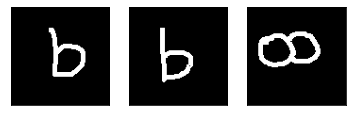

In [24]:
def plot_triplets(examples):
  plt.figure(figsize=(6,2))
  for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(np.reshape(examples[i], (105, 105)), cmap = 'binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

example = create_batch(1)
plot_triplets(example)

### 3.2 Rede geradora do vetor de características

Configure a rede que gera os vetores de características dos três caracteres das triplas  simultaneamente, para depois esses vetores serem unidos e calculadas as suas distâncias.

Crie a rede que gera os vetores de características dos três caracteres das triplas com a seguinte configuração:

- Rede convolucional sequencial;
- Camada convolucional com 64 filtros de dimensão 5x5 e função de ativação relu;
- Camada de maxpooling com janela 2x2 e stride 2;
- Camada convolucional com 128 filtros de dimensão 5x5 e função de ativação relu;
- Camada de maxpooling com janela 2x2 e stride 2;
- Camada convolucional com 256 filtros de dimensão 3x3 e função de ativação relu;
- Camada de maxpooling com janela 2x2 e stride 2;
- Camada convolucional com 512 filtros de dimensão 3x3 e função de ativação relu;
- Camada de "global average pooling" 

Apresente o sumário e o gráfico da sua rede.

Apresente a dimensão dos vetores de características gerados por essa rede para cada imagem.

Teste a sua rede geradora de características para algumas imagens do conjunto de treinamento e apresente alguns elementos dos vetores de características.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 101, 101, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 256)      0

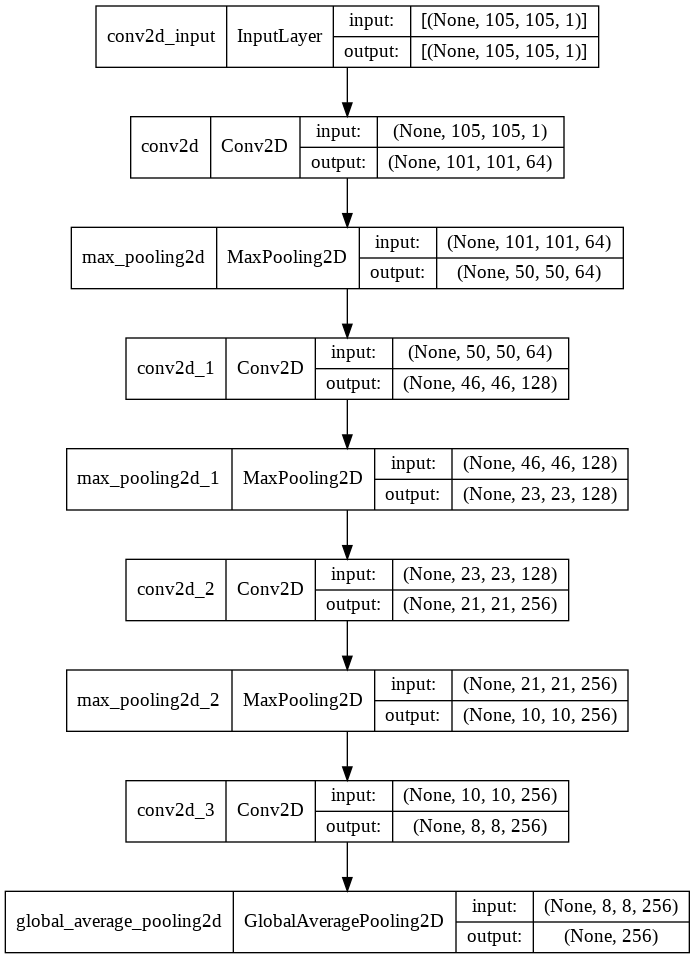

In [25]:
from tensorflow.keras import layers
from tensorflow.keras import models 
from tensorflow.keras import optimizers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import plot_model 

input = (105, 105, 1)

model = Sequential()
model.add(layers.Conv2D(64, (5, 5), activation = 'relu', input_shape = input))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(layers.GlobalAveragePooling2D())

model.summary()
plot_model(model, show_shapes=True)

In [26]:
example = np.expand_dims(x_train_flat[0], axis = 0)
example_carac = model.predict(example)

print('Dimensão de X_train_flat2:', x_train_flat.shape)
print('Dimensão de X_train_flat2[0].shape:', x_train_flat[0].shape)
print('Dimensão do exemplo', example.shape)
print('Dimensão do vetor de caracteristicas = ', example_carac.shape)
print('Exemplo de vetor de cacterísticas: \n', example_carac)

Dimensão de X_train_flat2: (19280, 105, 105)
Dimensão de X_train_flat2[0].shape: (105, 105)
Dimensão do exemplo (1, 105, 105)
Dimensão do vetor de caracteristicas =  (1, 256)
Exemplo de vetor de cacterísticas: 
 [[1.72657855e-02 3.51440278e-03 1.08107859e-02 0.00000000e+00
  1.00443862e-01 9.35392752e-02 0.00000000e+00 0.00000000e+00
  1.67236547e-04 0.00000000e+00 5.48024545e-05 2.87586749e-02
  1.13427568e-05 3.52720031e-06 0.00000000e+00 7.07188100e-02
  7.94980006e-05 8.25253129e-03 2.95910966e-02 1.89222884e-03
  0.00000000e+00 2.87275352e-02 0.00000000e+00 0.00000000e+00
  8.52015093e-02 3.45085226e-02 9.58039686e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.44256721e-03 4.69449833e-02 5.80675900e-04 0.00000000e+00
  2.99894884e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.77615765e-02 2.57810927e-03
  3.59622971e-03 1.41110935e-03 4.21774387e-03 0.00000000e+00
  0.00000000e+00 2.20112197e-04 2.41428837e-

### 3.3 Rede Siamesa

Configure a rede siamesa que processa simultaneamente os 3 exemplos de cada tripla. 

Apresente o sumário e o gráfico da sua rede.

Apresente a dimensão do vetor de saída dessa rede e alguns elementos desse vetor após processar algumas triplas.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                            

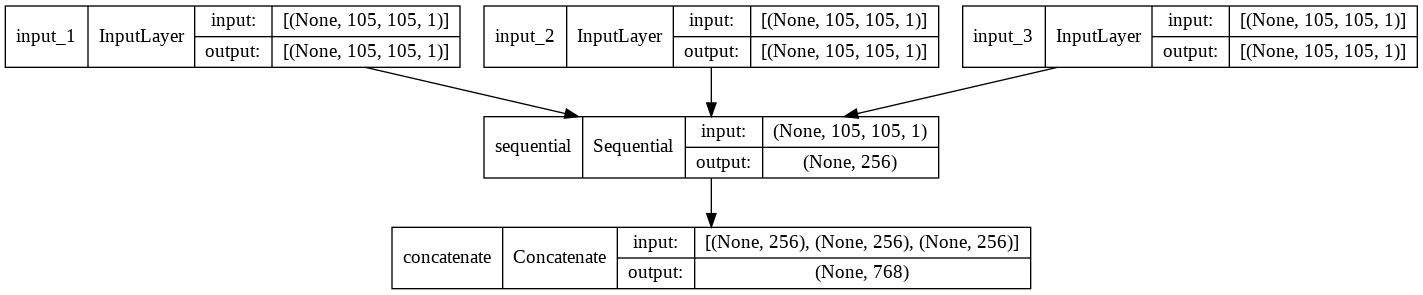

In [27]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input

input_reference = Input(shape=(105, 105, 1))
input_positive = Input(shape=(105, 105, 1))
input_negative = Input(shape=(105, 105, 1))

carac_reference = model(input_reference)
carac_positive = model(input_positive)
carac_negative = model(input_negative)

output = tf.keras.layers.concatenate([carac_reference, carac_positive, carac_negative], axis=1)

rna_siam = tf.keras.models.Model([input_reference, input_positive, input_negative], output)

rna_siam.summary()
plot_model(rna_siam, show_shapes=True)

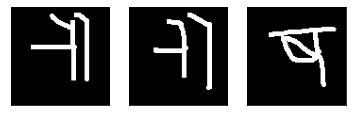

(1, 768)

[[1.75668560e-02 4.81062988e-03 1.18939830e-02 0.00000000e+00
  1.04376942e-01 9.42175835e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.94965527e-04 2.84142904e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.05203339e-02
  1.55194153e-04 6.88565057e-03 2.56326087e-02 2.04680907e-03
  0.00000000e+00 3.41593921e-02 0.00000000e+00 0.00000000e+00
  9.13909450e-02 3.41003239e-02 9.63005722e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.20620907e-03 4.65964749e-02 6.34810422e-05 0.00000000e+00
  2.29427181e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.39658819e-02 1.45324226e-03
  3.05853086e-03 2.89291749e-03 5.15324390e-03 0.00000000e+00
  0.00000000e+00 3.70201124e-05 2.95542646e-02 4.17952761e-02
  0.00000000e+00 0.00000000e+00 1.00162495e-02 5.01814159e-03
  7.23430794e-03 0.00000000e+00 0.00000000e+00 3.35830338e-02
  2.49705324e-03 7.18910154e-03 8.94595608e-02 1.12725243e-0

In [28]:
example = create_batch(1)
plot_triplets(example)

y_prev = rna_siam.predict(example)

print(y_prev.shape)
print()
print(y_prev)

### 3.4 Função de custo tripla

Crie uma função que calcula a função de custo usada para treinar os exemplos formados por triplas.

Teste a função de custo para verificar seu funcionamento usando a saída calculada no item 3 e apresente o valor calculado.

In [35]:
n_carac = 256
alpha = 0.2

def triplet_loss(y_true,y_pred):

  ref, positive, negative = y_pred[:,:n_carac], y_pred[:,n_carac:2*n_carac], y_pred[:,2*n_carac:]
  positive_dist = tf.reduce_mean(tf.square(ref-positive), axis=1)
  negative_dist = tf.reduce_mean(tf.square(ref-negative), axis=1)
  L = tf.maximum(positive_dist - negative_dist + alpha, 0.)

  return L

In [36]:
y_true = np.zeros(y_prev.shape)
L = triplet_loss(y_true,y_prev)
print(format(L))

[0.19999607]


### 3.5 Gerador de triplas

Para evitar de criar as triplas previamente, é usado um gerador de dados para fazer isso durante o treinamento. Assim, crie um gerador de dados para criar as triplas durante o treinamento. Observe que os dados de entrada de treinamento já  estão no tensor `X_train` e os dados de validação no tensor `X_val`. Observe que nesse gerador não é necessário carregar as imagens dos arquivos, pois elas já estão nesses dois tensores.

Teste o seu gerador criando alguns exemplos de treinamento. Mostra as imagens dos exemplos usados nesse teste.

In [37]:
def data_generator(batch_size=256):
  while True:
    x = create_batch(batch_size)
    y = np.zeros((batch_size, 3 * n_carac))
    yield x, y

x, y = next(data_generator(4))
print(len(x), len(y))
print(x[0].shape)

3 4
(4, 105, 105)


### 3.6 Treinamento da rede siamesa

Treine a sua rede siamesa. Nesse treinamento utilize os seguintes parâmetros:

- Método de otimização: Adam.
- Utlize as imagens de treinamento e de validação.
- Escolha a taxa de aprendizado e o número de épocas mais adequados para obter bons resultados.

Observe que para treinar a rede usando os dados de validação, é necessário criar também um gerador de dados de validação. Esse gerador é exatamente igual ao gerador de dados de treinamento, porém ele recebe os dados de validação.

Apresente o grafico da função de custo em função das épocas de treinamento para os dados de treinamento e de validação.

In [39]:
batch_size = 350
epochs = 20

steps_per_epoch = int(x_train_flat.shape[0]/batch_size)
rna_siam.compile(loss= triplet_loss, optimizer='adam')
history = rna_siam.fit(data_generator(batch_size), steps_per_epoch = steps_per_epoch, epochs = epochs, verbose=1)

Epoch 1/20
55/55 [==============================] - 76s 1s/step - loss: 0.1115
Epoch 2/20
55/55 [==============================] - 69s 1s/step - loss: 0.0509
Epoch 3/20
55/55 [==============================] - 69s 1s/step - loss: 0.0335
Epoch 4/20
55/55 [==============================] - 69s 1s/step - loss: 0.0260
Epoch 5/20
55/55 [==============================] - 69s 1s/step - loss: 0.0204
Epoch 6/20
55/55 [==============================] - 69s 1s/step - loss: 0.0192
Epoch 7/20
55/55 [==============================] - 69s 1s/step - loss: 0.0167
Epoch 8/20
55/55 [==============================] - 69s 1s/step - loss: 0.0133
Epoch 9/20
55/55 [==============================] - 69s 1s/step - loss: 0.0133
Epoch 10/20
55/55 [==============================] - 69s 1s/step - loss: 0.0118
Epoch 11/20
55/55 [==============================] - 69s 1s/step - loss: 0.0114
Epoch 12/20
55/55 [==============================] - 69s 1s/step - loss: 0.0104
Epoch 13/20
55/55 [==============================


### 3.7 Avaliação e teste da rede siamesa

Para avaliar a rede siamesa calcule o seguinte:

1. Valor da função de custo para os dados de treinamento e de validação. 

2. Calcule algumas previsões da rede para alguns exemplos e verifique o resultado.

In [54]:
def create_test_batch(batch_size = 256):
  x_refs = np.zeros((batch_size, 105, 105))
  x_positives = np.zeros((batch_size, 105, 105))
  x_negatives = np.zeros((batch_size, 105, 105))

  for i in range(0, batch_size):
    random_index = random.randint(0, x_test_flat.shape[0]-1)
    x_ref = x_test_flat[random_index]
    y = y_test_normalized[random_index]

    indices_for_pos = np.squeeze(np.where(y_test_normalized == y))
    indices_for_neg = np.squeeze(np.where(y_test_normalized != y))

    x_positive = x_test_flat[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
    x_negative = x_test_flat[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]

    x_refs[i] = x_ref
    x_positives[i] = x_positive
    x_negatives[i] = x_negative

  return[x_refs, x_positives, x_negatives]


def test_data_generator(batch_size = 256):

  while True:
    x = create_test_batch(batch_size)
    y = np.zeros((batch_size, 3 * n_carac))
    yield x, y

In [55]:
steps = int(x_test_flat.shape[0]/batch_size)
custo = rna_siam.evaluate(test_data_generator(batch_size), steps=steps)

37/37 [==============================] - 16s 414ms/step - loss: 0.0104


### 3.8 Teste de previsão da rede

Em operação uma rede siamesa tem a função de verificar se dois exemplos de dados pertencem à mesma classe ou não. Assim, a operação da rede siamesa é diferente do seu treinamento e não usa a função de custo tripla.

O processo de uso da rede siamesa após o seu treinamento é o seguinte:

1. A rede siamesa deve receber somente dois exemplos de treinamento e calcular os vetores de características de cada um desses exemplos, $\mathbf{v}_1$ e $\mathbf{v}_2$.


2. Tendo esses vetores de características, é calculada a distância entre eles usando a distância média quadrática, ou seja:

$$d_{1,2} = ||\mathbf{v}_1 − \mathbf{v_2}||^2$$

3. A distância $d_{1,2}$ é comparada com um $limiar$ para determinar se os dois exemplos são "iguais" ou "diferentes", ou seja:

    - Se $d <= limiar$, então os dois exemplos pertencem à mesma classe

    - Se $d > limiar$, então os dois exemplos pertencem a classes diferentes


#### Prepara dados de entrada

Vamos verificar as classes do primeiros 20 exemplos de teste para podermos testar a rede siamesa

In [59]:
for i in range(20):
  print(i, y_test_normalized[i])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0


(1, 105, 105) (1, 105, 105)


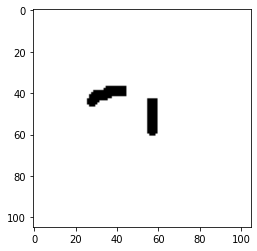

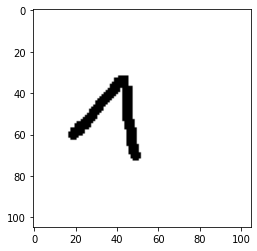

(1, 105, 105) (1, 105, 105)


In [63]:
ind1 = 4
ind2 = 6

x1 = np.expand_dims(x_test_flat[ind1], 0)
x2 = np.expand_dims(x_test_flat[ind2], 0)

print(x1.shape, x2.shape)

plt.imshow(x_test_flat[ind1], cmap='gray')
plt.show()
plt.imshow(x_test_flat[ind2], cmap='gray')
plt.show()
print(x1.shape, x2.shape)

### 3.9 Uso da rede siamensa para classificar caracteres


#### Calcule os vetores de características de referência

Para usar a rede siamensa para classificar caracteres deve-se ter os vetores de referências de todos os carateres. Assim, selecione 5 exemplos de cada caractere do conjunto de validação e calcule os vetores de caracteríticas de todos esses exemplos e os guarde em um tensor de características de referências.

Apresente alguns desses caracteres selecionados como referências, as sua dimensões e alguns elementos dos seus vetores de carcaterísticas. 


####  Determinação da classe de alguns exemplos

Ao receber uma imagem de um caractere para verificação a classe, o vetor de característica dessa imagem é calculado e são calculadas as distâncias desse vetor para os vetores de referência de cada uma das classes. A menor distância indica a que classe é a imagem.

Selecione diversos exemplos do conjunto de validação, pelo menos um caractere de cada tipo (utilize exemplos diferentes dos  usados como referências) e verifique o desempenho do seu classificador em determinar o tipo de caratere.

Apresente os resultados das classes reais e as previstas pelo seu classificador.

In [67]:
v1 = model(x1)
v2 = model(x2)

d12 = np.mean(np.square(v1-v2), axis=1)
print(d12)

if d12<=alpha:
  print('iguais')
else:
  print('diferentes')

[0.3543638]
diferentes


In [70]:
Nc = 10

v_ref = np.zeros((Nc, 5, n_carac))

for i in range(Nc):

  yind = np.where(y_train_normalized==i)
  z = x_train_flat[yind[0][:5]]

  v_ref[i,:5,:] = model(z)

print(v_ref.shape)

(10, 5, 256)


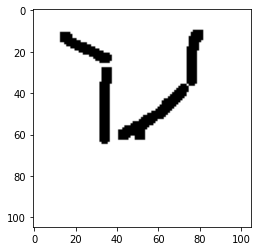

[[0.94572294]
 [1.24439383]
 [0.73667103]
 [0.68354833]
 [0.95847285]
 [0.98102421]
 [0.97387248]
 [1.6614157 ]
 [2.2619288 ]
 [1.99718547]]
3


In [71]:
ind = 20
x = np.expand_dims(x_test_flat[ind],0)

plt.imshow(x_test_flat[ind], cmap='gray')
plt.show()

v = model(x)

d = np.zeros((Nc,1))
for i in range(Nc):
  d[i] = 10_000.0
  for j in range(5):
    dj = np.mean(np.square(v - v_ref[i,j,:]), axis=1)
    if dj < d[i]:
      d[i] = dj

print(d)

classe = np.argmin(d)
print(classe)

### 3.10 Conclusão

- Quando não temos muitos dados de treino, é interessante o uso das redes siamesas;
- É uma rede eficiente para separar classes